In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#design network
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input, Conv2D

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Dense, Dropout, Average, Add, MaxPooling2D, SimpleRNN, Concatenate, GlobalAveragePooling2D, Reshape, GRU
from keras import Model
from tensorflow.keras.utils import to_categorical

In [2]:
# from helpers import pre_processing_wlan_utils as preprocess_utils
# from helpers import classifier_wlan_spectral_utils as classifier_utils

In [3]:
# import importlib
# # importlib.reload(tr_models)
# importlib.reload(classifier_utils)
# importlib.reload(preprocess_utils)

In [4]:
# task = 'app-type'
# label = preprocess_utils.label_index[task]
# num_classes = preprocess_utils.num_classes[task]
# labels_string = preprocess_utils.labels_string[task]
# print("Label id: ", label)
# print("Num classes in that label: ", num_classes)
# print("Labels: ", labels_string)

In [5]:
# if (task == 'app') or (task == 'app-type'):
#     num_classes = num_classes-1
#     labels_string = labels_string[0:num_classes]
#     print("Label id: ", label)
#     print("Num classes in that label: ", num_classes)
#     print("Labels: ", labels_string)

In [6]:
# seq_length = 3000

# #Set type of padding. 
# padding = 'post'

# #Set path to dataset folder. All the files from the dataset can be downloaded from https://zenodo.org/record/5208201
# dataset_folder = './waveforms/'

# #Set name of dataset file. In this case we are using once of the balanced dataset (filename_balanced.mat)
# dataset_filename = 'waveforms_2G_n_'+task+'_balanced.mat'

In [7]:
# Xraw, Yraw = classifier_utils.get_raw_xy_spectrum(dataset_folder,dataset_filename)

In [8]:
# print("Padding/Truncating sequence to a length of ",str(seq_length))
# X = classifier_utils.pad_or_trunc_x_and_scale(Xraw, seq_length, padding, scale=True)

In [9]:
# plt.plot(X[0,0,:])

In [10]:
# X.shape

In [11]:
# print("Generate one-shot labels")
# Y = classifier_utils.get_one_hot_labels(Yraw, num_classes, label)

In [12]:
# from numpy import savez_compressed
# savez_compressed('x_app_type.npz', X)
# savez_compressed('y_app_type.npz', Y)

X= np.load('x_app_type.npz')
X=X['arr_0']
Y= np.load('y_app_type.npz')
Y=Y['arr_0']
print(X.shape)
print(Y.shape)

(117159, 2, 3000)
(117159, 3)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [14]:
X_test.shape

(23432, 2, 3000)

In [15]:
# seed = 42
# print("Performing data splitting")
# X_train, X_val, X_test, Y_train, Y_val, Y_test = classifier_utils.get_xy_4_training(X,Y,seed)
# print(X_train.shape,X_val.shape, X_test.shape)

In [16]:
X_train=X_train.reshape((93727,3000,2,1))
# X_val=X_val.reshape((7160,3000,2,1))
X_test=X_test.reshape((23432,3000,2,1))

In [17]:
def conv_block(xin,f,k,p,d):
    x=Conv2D(f,(k,1), activation="relu", padding='same', kernel_initializer="glorot_normal")(xin)
    x=MaxPooling2D((p,p), padding='same')(x)
    x=Dropout(d)(x)
    x=BatchNormalization(axis=-1)(x)
    return x

In [18]:
def clf_block(xin, n, d):
    x=Dense(n, activation='relu')(xin)
    x=Dropout(d)(x)
    x=BatchNormalization(axis=-1)(x)
    return x

In [19]:
xin= Input(shape=(3000,2,1))
x1=conv_block(xin,64,32,2,0.1)
x2=conv_block(x1,64,32,2,0.1)
x3=conv_block(x2,64,32,2,0.1)
x4=conv_block(x3,64,32,2,0.1)
x5=conv_block(x4,64,32,2,0.1)
x6=conv_block(x5,64,32,2,0.1)
x7=conv_block(x6,64,32,2,0.1)
x=Concatenate(axis=1)([x5,x6,x7])

x=Reshape((64,165), input_shape=(353,1,165))(x)

x=GRU(20)(x)

# # # x=Dropout(.1)(x)

x=clf_block(x,1024,0.1)
# # x=clf_block(x,128,0.1)
x=Dense(3, activation='softmax')(x)

model = Model(inputs=xin, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3000, 2, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 3000, 2, 64)  2112        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1500, 1, 64)  0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 1500, 1, 64)  0           ['max_pooling2d[0][0]']      

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [22]:
EPOCHS = 100
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
#history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_test,y_test),callbacks=[callback], batch_size=64)
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_test,y_test), batch_size=64)

Epoch 1/100
1465/1465 [==============================] - 50s 30ms/step - loss: 0.4465 - accuracy: 0.7996 - val_loss: 0.2393 - val_accuracy: 0.9022
Epoch 2/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.1917 - accuracy: 0.9221 - val_loss: 0.1405 - val_accuracy: 0.9482
Epoch 3/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.1318 - accuracy: 0.9482 - val_loss: 0.1097 - val_accuracy: 0.9555
Epoch 4/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.1019 - accuracy: 0.9600 - val_loss: 0.0758 - val_accuracy: 0.9691
Epoch 5/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.0804 - accuracy: 0.9690 - val_loss: 0.0766 - val_accuracy: 0.9703
Epoch 6/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.0693 - accuracy: 0.9729 - val_loss: 0.0646 - val_accuracy: 0.9755
Epoch 7/100
1465/1465 [==============================] - 44s 30ms/step - loss: 0.0649 - accuracy: 0.9754 - val_loss: 0

1465/1465 [==============================] - 43s 29ms/step - loss: 0.0247 - accuracy: 0.9891 - val_loss: 0.0399 - val_accuracy: 0.9836
Epoch 57/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.0246 - accuracy: 0.9892 - val_loss: 0.0409 - val_accuracy: 0.9854
Epoch 58/100
1465/1465 [==============================] - 43s 30ms/step - loss: 0.0241 - accuracy: 0.9893 - val_loss: 0.0415 - val_accuracy: 0.9851
Epoch 59/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.0242 - accuracy: 0.9895 - val_loss: 0.0407 - val_accuracy: 0.9851
Epoch 60/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.0243 - accuracy: 0.9891 - val_loss: 0.0416 - val_accuracy: 0.9838
Epoch 61/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.0227 - accuracy: 0.9897 - val_loss: 0.0415 - val_accuracy: 0.9855
Epoch 62/100
1465/1465 [==============================] - 43s 29ms/step - loss: 0.0231 - accuracy: 0.9896 - val_loss: 0.0378 

In [23]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=1)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    
    print(history)
    fig1, ax_acc = plt.subplots(figsize=(8, 6))
    
    ax_acc.tick_params(axis="y",direction="in",which="both",labelsize=12)
    ax_acc.tick_params(axis="x",direction="in",which="both",labelsize=12)
    plt.plot(history.history['accuracy'], color='r', linewidth=2)
    plt.plot(history.history['val_accuracy'], color='b', linewidth=2)
    
    csfont = {'fontname':'Times New Roman'}
    
    plt.xlabel('Epoch',fontsize=17,**csfont)
    plt.ylabel('Accuracy',fontsize=17,**csfont)
#     plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right',prop={"family":'Times New Roman', "size":17})
#     plt.show()
    plt.savefig('app_type.png')
    
#     fig2, ax_loss = plt.subplots()
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Model- Loss')
#     plt.legend(['Training', 'Validation'], loc='upper right')
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.show()
#     target_names=['0','1','2']
    
    
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

733/733 [==============================] - 5s 6ms/step - loss: 0.0488 - accuracy: 0.9851
Accuracy: 98.51%


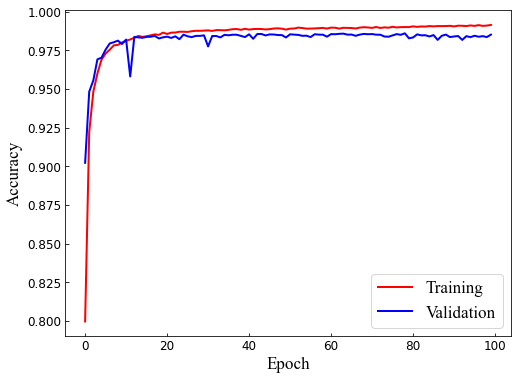

In [24]:
from sklearn.metrics import confusion_matrix


evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Confusion matrix, without normalization


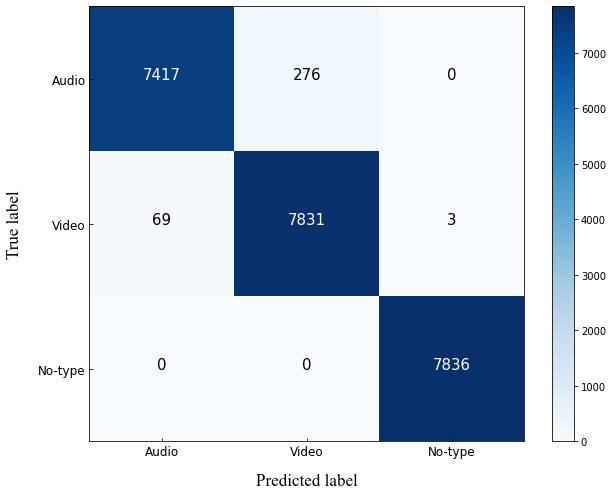

In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.tick_params(axis="y",direction="in",which="both")
    ax.tick_params(axis="x",direction="in",which="both")
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    csfont = {'fontname':'Times New Roman'}
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=15)

#     plt.tight_layout()
    plt.ylabel('True label',labelpad=15, fontsize=17,**csfont)
    plt.xlabel('Predicted label', labelpad=15,fontsize=17,**csfont)

    
    # Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=["Audio", "Video", "No-type"])
# plt.show()
plt.savefig('app_type CM.png')

In [26]:
from sklearn import metrics
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.991     0.964     0.977      7693
           1      0.966     0.991     0.978      7903
           2      1.000     1.000     1.000      7836

    accuracy                          0.985     23432
   macro avg      0.985     0.985     0.985     23432
weighted avg      0.985     0.985     0.985     23432

